<a href="https://colab.research.google.com/github/fabriciosantana/nlp/blob/main/AKCIT_NLP_M7_Colab_Unidade_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Processamento de Linguagem Natural utilizando a biblioteca Hugging Face Transformers

## 1- Objetivos de Aprendizagem

Neste Notebook, vamos explorar exemplos reais de soluções para tarefas de Processamento de Linguagem Natural (NLP) utilizando a biblioteca Hugging Face Transformers. Nosso primeiro exemplo será o *fine-tuning* do modelo BERT para a análise de sentimentos em português. Em seguida, apresentaremos dois exemplos utilizando apenas modelos pré-treinados com os *pipelines* da Hugging Face. O segundo exemplo demonstrará o uso de* Named Entity Recognition* (NER), e o terceiro exemplo abordará a tradução automática. Estes exemplos práticos fornecerão uma visão abrangente de como aplicar técnicas avançadas de NLP para resolver problemas do mundo real.



# 2- *Fine-Tuning* do BERT para Análise de Sentimentos

Neste tópico, vamos realizar o *fine-tunin*g do modelo BERT para a tarefa de análise de sentimentos utilizando a biblioteca Hugging Face Transformers. Vamos usar um *dataset* de comentários sobre compras em português.

**Importante:** Para o treinamento deve ser usada a rumtime com **GPU**.


## 2.1- Instalação das Dependências

Vamos começar instalando as bibliotecas necessárias.

In [ ]:
!pip install transformers
!pip install datasets
!pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.6 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


## 2.2- Configuração de variáveis globais

Vamos configurar as variáveis de parâmetros para serem utilizadas durante o código.

In [ ]:
# model_id = "neuralmind/bert-base-portuguese-cased"
model_id = "adalbertojunior/distilbert-portuguese-cased"
max_length= 512
num_labels = 3
batch_size = 28
results_path = "./results"
pretrained_path = "./sentiment-analysis-bert-portuguese"

##2.3- Importação das Bibliotecas

Vamos importar as bibliotecas necessárias para carregar o *dataset*, tokenizar os textos, configurar o modelo BERT, e realizar o treinamento e avaliação.

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
from datasets import load_dataset, load_metric, DatasetDict
from torch.utils.data import DataLoader, SequentialSampler
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

## 2.4- Carregar o *Dataset*

Vamos carregar um *dataset* de comentários de pedidos em português.
Para este exemplo, vamos utilizar o *dataset* `verissimomanoel/olist_customers_review` da Hugging Face, que contém comentários rotulados para análise de sentimentos.
No dataset já tem uma parte de treino `train` e outra de para teste `test`. Contudo precisamos dividir o treino mais uma vez para ter uma parte para validação `val` que será usada durante o treino.

In [ ]:
# Carrega o dataset que tem train e test
dataset = load_dataset("verissimomanoel/olist_customers_review", trust_remote_code=True)

# Divide o treino em 80% e 20%, sendo os 80 para treino e os 20 para validação
ds_train_split = dataset["train"].train_test_split(test_size=0.2)

# Monta o dataset com todas as partes train, test e val
dataset = DatasetDict({
    "train": ds_train_split["train"],
    "test": dataset["test"],
    "val": ds_train_split["test"],
})

# Separa as partes do dataset
train_dataset = dataset['train']
test_dataset = dataset['test']
val_dataset = dataset['val']

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/33395 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/8349 [00:00<?, ? examples/s]

## 2.5- Visualização do *Dataset*

Vamos visualizar a estrutura do *dataset* carregado. Para tal, as sequências de código [6] e [7] abaixo mostrarão, na forma de gráfico, os conjuntos de dados para treino, teste e validação.

In [ ]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 26716
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 8349
    })
    val: Dataset({
        features: ['text', 'label'],
        num_rows: 6679
    })
})


In [ ]:
def show_info_dataset(dataset, title):
    # Converter o dataset para um DataFrame do pandas
    df = dataset.to_pandas()

    # Contar as ocorrências na coluna 'label'
    label_counts = df['label'].value_counts()

    # Mapeamento dos labels para nomes
    label_names = {0: 'Negativo', 1: 'Positivo', 2: 'Neutro'}

    # Obter os nomes das labels
    labels = [label_names[label] for label in label_counts.index]

    # Definir as cores para cada label
    colors = ['green', 'red', 'blue']

    # Plotar o gráfico de barras
    plt.figure(figsize=(10, 6))
    bars = plt.bar(labels, label_counts, color=colors)

    # Adicionar os totais em cima das barras
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom')  # va: vertical alignment

    # Configurar o título e os rótulos dos eixos
    plt.title(title)
    plt.xlabel('Label')
    plt.ylabel('Total')
    plt.show()

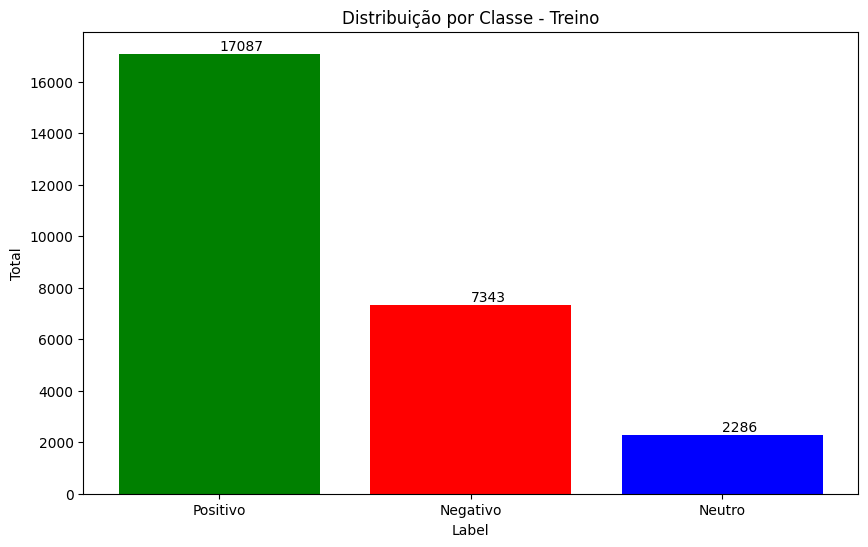

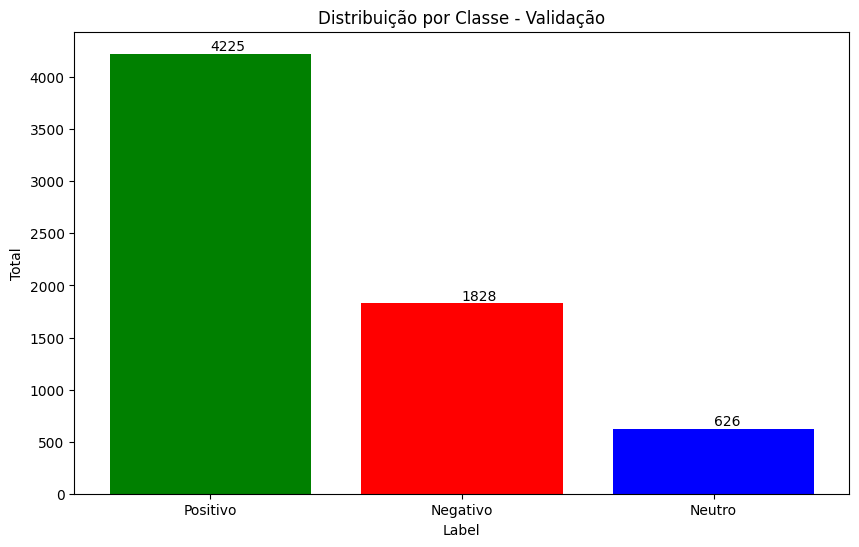

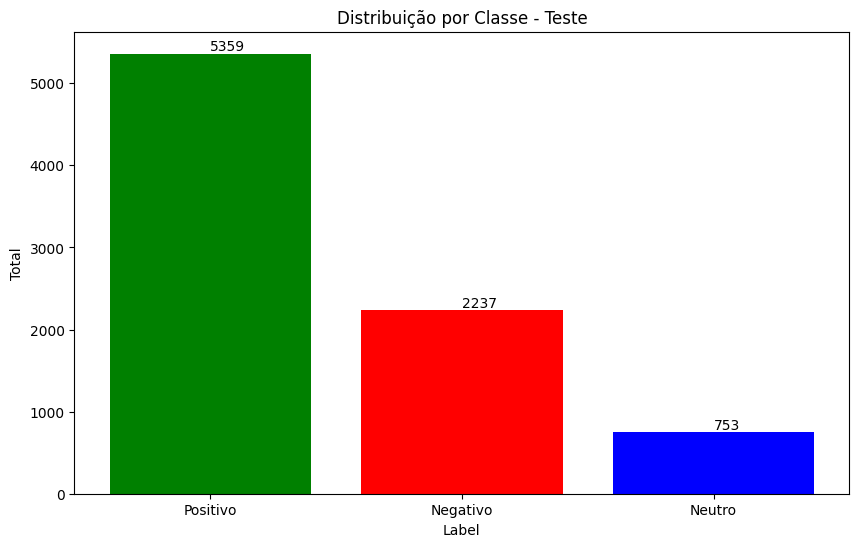

In [ ]:
show_info_dataset(train_dataset, 'Distribuição por Classe - Treino')
show_info_dataset(val_dataset, 'Distribuição por Classe - Validação')
show_info_dataset(test_dataset, 'Distribuição por Classe - Teste')

## 2.6- Tokenização do *Dataset*

Vamos carregar o tokenizer do BERT e usá-lo para tokenizar os textos no *dataset.* Vamos usar o modelo `neuralmind/bert-base-portuguese-cased`, que é um BERT treinado em português.

O comando train_dataset.shuffle().select(range(5000)) é responsaável pelo
embaralhamento e seleção de amostras. Neste caso está selecionando as primeiras 5000 amostras do conjunto de dados embaralhado.

O comando train_dataset.map(tokenize_function, batched=True) realiza a tokenização no conjunto de dados de treinamento (train_dataset) e usa a função map() para aplicar a função de tokenização a cada lote de amostras do conjunto de dados. Com batched=True, a função é aplicada em lotes de amostrase não em uma amostra por vez, isso torna o processo mais eficiente.

In [ ]:
tokenizer = BertTokenizer.from_pretrained(model_id)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=max_length)

# Reduz o tamanho dos datasets apenas para conseguir rodar no Google Colab por menos tempo, para rodar com o dataset completo só comentar as próximas 3 linhas
train_dataset = train_dataset.shuffle().select(range(5000))
test_dataset = test_dataset.shuffle().select(range(1000))
val_dataset = test_dataset.shuffle().select(range(800))

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)

## 2.7- Formatando o Dataset

Vamos definir o formato dos datasets para que o *Trainer* da Hugging Face possa processá-los corretamente.

*   **set_format(type='torch', columns=['input_ids', 'attention_mask', 'label']):** Este método converte os datasets para o formato do **PyTorch** (tensors) para que possam ser usados diretamente em redes neurais. A função especifica que apenas as colunas input_ids, attention_mask e label serão mantidas no formato final.

  *   **input_ids:** Contém os identificadores numéricos que representam as palavras ou tokens da entrada.

  *   **attention_mask:** Indica quais tokens são relevantes (1) e quais são padding (0), para que o modelo saiba onde prestar atenção.

  *   **label:** São as etiquetas associadas a cada exemplo, que o modelo deve prever (por exemplo, para uma tarefa de classificação).

In [ ]:
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

## 2.8- Configuração do Modelo BERT

Vamos configurar o modelo BERT para a tarefa de classificação de sequência. Neste caso, estamos utilizando a versão `neuralmind/bert-base-portuguese-cased` do modelo.

In [ ]:
model = BertForSequenceClassification.from_pretrained(model_id, num_labels=num_labels)

## 2.9- Função de Avaliação

Vamos definir uma função de avaliação para calcular a precisão do modelo durante a avaliação. Utilizaremos a métrica de precisão (`accuracy`) fornecida pela biblioteca `datasets`.

In [ ]:
metric = load_metric("accuracy", trust_remote_code=True)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    # Transforma os logits (saída do modelo) em previsões de classe, atribuindo a cada exemplo a classe com a
    # maior probabilidade, ou seja, a que tem o maior valor de logit.
    predictions = torch.argmax(torch.tensor(logits), dim=-1)

    return metric.compute(predictions=predictions, references=torch.tensor(labels))

## 2.10- Configuração dos Argumentos de Treinamento

Vamos definir os parâmetros de treinamento, incluindo a taxa de aprendizado, tamanho do batch, número de épocas, e a estratégia de avaliação.

In [ ]:
training_args = TrainingArguments(
    output_dir=results_path,                  # Diretório de saída para os resultados
    evaluation_strategy="epoch",              # Estratégia de avaliação (avaliar a cada época)
    learning_rate=3e-5,                       # Taxa de aprendizado
    per_device_train_batch_size=batch_size,   # Tamanho do batch de treino
    per_device_eval_batch_size=batch_size,    # Tamanho do batch de avaliação
    num_train_epochs=3,                       # Número de épocas de treinamento
    weight_decay=0.01,                        # Decaimento de peso
)

## 2.11- Treinamento do Modelo

Vamos criar um objeto `Trainer` com o modelo, dados de treino e validação, e os argumentos de treinamento definidos nos comando acima. Em seguida, vamos iniciar o treinamento do modelo.

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

## 2.12- Avaliação do Modelo - *Evaluate*

Vamos avaliar o modelo no conjunto de teste ( com o comando trainer.evaluate) e exibir a precisão com a função show_info logo abaixo.

In [ ]:
results = trainer.evaluate(eval_dataset=test_dataset)
print(f"Acurácia no conjunto de teste: {results['eval_accuracy']}")

## 2.13- Avaliação do Modelo - *Predict*

Vamos avaliar o modelo no conjunto de teste e exibir a matriz de confusão.

In [ ]:
raw_pred, _, _ = trainer.predict(test_dataset=test_dataset)

In [ ]:
def show_info(y_true, y_pred, title='Confusion matrix', cmap='Blues'):
    target_names = ['Negativo', 'Positivo', 'Neutro']
    print(classification_report(y_true, y_pred, target_names=target_names))

    plt.figure(figsize=(16, 10))
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
    fig, ax = plt.subplots(figsize=(10,10))
    disp.plot(ax=ax, xticks_rotation='vertical', cmap=plt.cm.Blues,values_format='g')
    plt.show()

In [ ]:
# Pré-processar previsões brutas
y_pred = np.argmax(raw_pred, axis=1)
y_true = test_dataset["label"]

show_info(y_true, y_pred)

## 2.14- Salvar o Modelo

Vamos salvar o modelo treinado e o tokenizer para uso futuro.

In [ ]:
model.save_pretrained(pretrained_path)
tokenizer.save_pretrained(pretrained_path)

## 2.15- Predição de Novos Exemplos

Vamos definir uma função para prever o sentimento de novas frases usando o modelo treinado. Em seguida, vamos testar o modelo com uma nova frase e exibir o resultado.

In [ ]:
def predict_sentiment(text):
    # Certificar que o modelo e os inputs estão no mesmo dispositivo (CPU ou GPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Tokeniza o texto, aplica padding e truncamento, converte para tensor PyTorch e move os dados para o dispositivo especificado.
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
    model.eval()
    with torch.no_grad():
        # Executa o modelo com as entradas fornecidas, passando os tensores de input como argumentos para gerar as previsões ou saídas do modelo.
        outputs = model(**inputs)

    # Aplica a função softmax as saídas do modelo para converter os valores em probabilidades, normalizadas ao longo da última dimensão.
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)

    # Retorna a maior probabilidade
    return probs.argmax().item()

example_text = "Eu adorei esse filme! Foi fantástico."
predicted_label = predict_sentiment(example_text)
sentiment = ['Negativo', 'Positivo', 'Neutro']
print(f"Sentimento previsto: {sentiment[predicted_label]}")

## 2.16- F1 *Score* - Importância em Datasets Desbalanceados

O F1 *Score* é uma métrica usada para avaliar a performance de um modelo de classificação, especialmente quando lidamos com datasets desbalanceados. Para entender o F1 Score, é importante conhecer alguns conceitos básicos:

1. **Acurácia (*Accuracy*)**: Métrica de avaliação utilizada para medir a proporção de previsões corretas em relação ao total de previsões feitas por um modelo de classificação. Ela é definida pela fórmula:
    $$
    \text{Acurácia} = \frac{TP + TN}{TP + TN + FP + FN}
    $$

Onde:
- **TP** (*True Positives*): Verdadeiros Positivos
- **TN** (*True Negatives*): Verdadeiros Negativos
- **FP** (*False Positives*): Falsos Positivos
- **FN** (*False Negatives*): Falsos Negativos

2. **Precisão (*Precision*)**: É a proporção de verdadeiros positivos (TP) entre todas as instâncias que o modelo previu como positivas. Em outras palavras, é a quantidade de previsões corretas de uma classe específica em relação ao total de previsões feitas para essa classe.
   $$
   \text{Precisão} = \frac{TP}{TP + FP}
   $$
   onde FP são os falsos positivos.

3. **Revocação (*Recall*)**: É a proporção de verdadeiros positivos entre todas as instâncias que são realmente positivas. Ou seja, é a quantidade de previsões corretas de uma classe específica em relação ao total de instâncias reais dessa classe.
   $$
   \text{Revocação} = \frac{TP}{TP + FN}
   $$
   onde FN são os falsos negativos.

4. **F1 Score**: É a média harmônica entre a Precisão e a Revocação. A média harmônica é usada aqui porque penaliza valores extremos, garantindo que o F1* Score* será baixo se um dos dois (Precisão ou Revocação) estiver baixo.
   $$
   \text{F1 Score} = 2 \times \frac{\text{Precisão} \times \text{Revocação}}{\text{Precisão} + \text{Revocação}}
   $$

### Por que usar o F1 Score em datasets desbalanceados?

Em datasets desbalanceados, onde uma classe é muito mais frequente do que outra, métricas como a acurácia podem ser enganosas. Por exemplo, se temos 95% das instâncias de uma classe e apenas 5% de outra, um modelo que sempre prevê a classe majoritária terá alta acurácia, mas não será útil para detectar a classe minoritária.

O F1 Score é importante porque leva em consideração tanto a Precisão quanto a Revocação. Em um cenário desbalanceado, isso ajuda a fornecer uma visão mais equilibrada da performance do modelo, destacando se ele é capaz de identificar a classe minoritária com precisão e frequência suficientes.

Assim, o F1 Score é particularmente útil quando a prioridade é garantir que tanto a taxa de detecção dos positivos (revocação) quanto a qualidade das detecções positivas (precisão) são importantes, o que é frequentemente o caso em situações desbalanceadas.

## 2.17- Exercícios *Fine-Tuning*


1.   Alterar alguns parâmetros de treinamento, como: batch_size, learning rate e número de épocas. Avaliar qual o impacto negativo ou positivo na alteração desses parâmetros.
2.   Utilizar alguma técnica de balanceamento de *dataset* e avaliar os resultados, Ex.: *Oversampling* e *Undersampling*



# 3- BERT para NER

Neste tópico, vamos demonstrar como usar a biblioteca Hugging Face Transformers e *pipelines* de um modelo já treinado para realizar *Named Entity Recognition *(NER) em textos em português. Utilizaremos um modelo pré-treinado adequado para a tarefa de NER.

## 3.1- Configuração de variáveis globais

Vamos configurar as variáveis de parâmetros para serem utilizadas durante o código.

In [ ]:
# Seleciona a versão do modelo que será utilizada
model_id = "lfcc/bert-portuguese-ner"

## 3.2- Importação das Bibliotecas

Vamos importar as bibliotecas necessárias para carregar o pipeline de NER e o *dataset* em português.

In [ ]:
from transformers import pipeline, AutoModelForTokenClassification, AutoTokenizer

## 3.3- Carregar o Modelo BERT para NER

Vamos carregar o *pipeline* de NER usando um modelo pré-treinado disponível na Hugging Face. Utilizaremos o modelo `xlm-roberta-base`, que é adequado para NER em português.

Ao carregar o *pipeline* NER, usando o  aggregation_strategy="simple" o modelo adotará a estratégia de agregaçao para unir tokens que pertençam a uma mesma entidade nomeada.

In [ ]:
# Carregando o modelo e tokenizer
model = AutoModelForTokenClassification.from_pretrained(model_id)
tokenizer = AutoTokenizer.from_pretrained(model_id)

# Carregando o pipeline de NER
ner_pipeline = pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy="simple")

## 3.4- Extraindo Entidades de Texto

Vamos utilizar o pipeline de NER para identificar entidades nomeadas em alguns exemplos de texto em português.

In [ ]:
# Definindo alguns exemplos de texto em português
examples = [
    "Paulo viajou para o Estados Unidos.",
    "Marie Curie foi uma cientista polonesa que realizou pesquisas pioneiras sobre radioatividade.",
    "Fernando Henrique Cardoso foi o primeiro presidente eleito após a ditadura no Brasil.",
    "Petrobras foi fundada em 3 de outubro de 1953"
]

# Realizando NER nos exemplos de texto
for example in examples:
    ner_results = ner_pipeline(example)
    print(f"Texto: {example}")
    print("Entidades Nomeadas:")
    for entity in ner_results:
        print(f" - {entity['word']}: {entity['entity_group']} ({entity['score']*100:.2f}%)")
    print()

# 4- **Tradução** Automática usando Hugging Face Transformers

Neste tópico, vamos demonstrar como usar a biblioteca Hugging Face Transformers e *pipelines* de um modelo já treinado para realizar a tradução automática de textos em português para o inglês. Utilizaremos um modelo pré-treinado adequado para a tarefa de tradução.

## 4.1- Importação das Bibliotecas

Vamos importar as bibliotecas necessárias para carregar o pipeline de tradução.

In [ ]:
from transformers import pipeline

## 4.2- Carregar o Modelo de Tradução

Vamos carregar o *pipeline* de tradução usando um modelo pré-treinado disponível na Hugging Face. Utilizaremos o modelo `Helsinki-NLP/opus-mt-pt-en`, que é adequado para tradução do português para o inglês.

In [ ]:
# Carregando o pipeline de tradução
translation_pipeline = pipeline("translation_en_to_pt", model="Helsinki-NLP/opus-mt-tc-big-en-pt")

## 4.3- Exemplos de Tradução

Vamos utilizar o* pipeline* de tradução para traduzir alguns exemplos de texto em português para o inglês.

In [ ]:
# Definindo alguns exemplos de texto em português
examples = [
    "I love learning about natural language processing.",
    "The BERT model was developed by Google AI Research.",
    "Machine translation is a challenging and interesting task."
]

# Realizando a tradução dos exemplos de texto
for example in examples:
    translation = translation_pipeline(example)
    print(f"Texto original: {example}")
    print(f"Tradução: {translation[0]['translation_text']}\n")

# 4.4- Exercício - Desafio
Para finalizar a seção do **BERT** do nosso curso fica o exercício desafio que será divido em três partes:


1.   Utilizar o *dataset *`hate-speech-portuguese/hate_speech_portuguese` e dividi-lo em 3 partes `train`, `test` e `val`
2.   Usar o *dataset* dividido e avaliar somente a parte do `val`, rodar a predição no modelo `adalbertojunior/distilbert-portuguese-cased` e avaliar a métrica **F1 Score** que deve ser calculada usando o `load_metric` (https://huggingface.co/docs/evaluate/choosing_a_metric) do Hugging Face.
3.  Realizar um *fine-tunning* para esse *dataset* e avaliar a métrica **F1 Score** comparando. Compare o resuldado desse modelo com o do passo anterior e veja qual ficou melhor.